<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup-Model" data-toc-modified-id="Setup-Model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup Model</a></span><ul class="toc-item"><li><span><a href="#Fina-Tune-Model" data-toc-modified-id="Fina-Tune-Model-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Fina Tune Model</a></span></li><li><span><a href="#Create-Image-Data-Generator" data-toc-modified-id="Create-Image-Data-Generator-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Create Image Data Generator</a></span></li></ul></li><li><span><a href="#Train-Model" data-toc-modified-id="Train-Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Train Model</a></span></li><li><span><a href="#Model-Evaluation" data-toc-modified-id="Model-Evaluation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model Evaluation</a></span><ul class="toc-item"><li><span><a href="#Comparison-between-Training-and-Validation-Dataset-for-Accuracy-and-Loss" data-toc-modified-id="Comparison-between-Training-and-Validation-Dataset-for-Accuracy-and-Loss-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Comparison between Training and Validation Dataset for Accuracy and Loss</a></span><ul class="toc-item"><li><span><a href="#Confusion-Matrix" data-toc-modified-id="Confusion-Matrix-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Confusion Matrix</a></span></li></ul></li><li><span><a href="#Classification-Report" data-toc-modified-id="Classification-Report-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Classification Report</a></span></li></ul></li><li><span><a href="#Plot-Model" data-toc-modified-id="Plot-Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Plot Model</a></span></li></ul></div>

In [2]:
import numpy as np
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import os
from datetime import datetime


from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger,LearningRateScheduler
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling2D

#data location path
PROJECT_DIR = r"D:\CA2_Data"

TRAIN_DIR = os.path.join(PROJECT_DIR, "Train")
VALIDATION_DIR = os.path.join(PROJECT_DIR, "Validation")
LOG_DIR = os.path.join(PROJECT_DIR, "Log")
TIMESTAMP = "{0:%Y-%m-%dT%H-%M-%S/}".format(datetime.now())

seed        = 29
np.random.seed(seed)

In [3]:
train_file_count = sum([len(files) for r, d, files in os.walk(TRAIN_DIR)])
test_file_count = sum([len(files) for r, d, files in os.walk(VALIDATION_DIR)])
print("Training images: ", train_file_count)
print("Validation images: ", test_file_count)

Training images:  2423
Validation images:  724


# Setup Model

In [4]:
img_rows = 64
img_cols = 64
epochs = 80
batch_size = 32

optmz       = optimizers.Adam(lr=0.001)
modelname   = 'Model_CNN' 

LOG_DIR = os.path.join(PROJECT_DIR, modelname)

In [5]:
# set up model
def createModel():
    model = Sequential()
    model.add(Conv2D(32,(3,3),
                     input_shape=(img_rows,img_cols,3),
                     padding='same',
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(48,(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(96,(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128,(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dense(3,activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=optmz,
                  metrics=['accuracy'])

    return model

model       = createModel()  # This is meant for training
modelGo     = createModel()  # This is used for final testing

model.summary()

W0930 20:28:42.460091 13656 deprecation.py:506] From c:\users\guofe\workspace\nus_is_pr\venv\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 48)        13872     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        27712     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 96)          5

## Fina Tune Model

In [6]:
# Create checkpoint for the training
filepath        = os.path.join(PROJECT_DIR, modelname + ".hdf5")
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_acc', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

# Log the epoch detail into csv
csv_logger      = CSVLogger(os.path.join(PROJECT_DIR,  modelname +'.csv'))
callbacks_list  = [checkpoint,csv_logger]

## Create Image Data Generator

In [7]:
train_datagen = ImageDataGenerator()
validation_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                        target_size=(img_rows, img_cols), 
                                                        batch_size=batch_size, shuffle=False)

Found 2423 images belonging to 3 classes.
Found 724 images belonging to 3 classes.


# Train Model

In [8]:
history = model.fit_generator(train_generator,
                    validation_data=validation_generator,
                    epochs=epochs, 
                    verbose=1,
                    workers=8,
                    steps_per_epoch=train_generator.n//batch_size,
                    validation_steps=validation_generator.n//batch_size,
                    callbacks=callbacks_list)

Epoch 1/80
75/75 [==============================] - 17s 227ms/step - loss: 2.4750 - acc: 0.6144 - val_loss: 0.6845 - val_acc: 0.6974
Epoch 2/80
75/75 [==============================] - 2s 24ms/step - loss: 0.5947 - acc: 0.7541 - val_loss: 0.6522 - val_acc: 0.7273
Epoch 3/80
75/75 [==============================] - 2s 26ms/step - loss: 0.5449 - acc: 0.7788 - val_loss: 0.5623 - val_acc: 0.7756
Epoch 4/80
75/75 [==============================] - 2s 26ms/step - loss: 0.4197 - acc: 0.8411 - val_loss: 0.4800 - val_acc: 0.8196
Epoch 5/80
75/75 [==============================] - 2s 23ms/step - loss: 0.3477 - acc: 0.8649 - val_loss: 0.4474 - val_acc: 0.8438
Epoch 6/80
75/75 [==============================] - 2s 24ms/step - loss: 0.2955 - acc: 0.8846 - val_loss: 0.5085 - val_acc: 0.8125
Epoch 7/80
75/75 [==============================] - 2s 26ms/step - loss: 0.2330 - acc: 0.9096 - val_loss: 0.4887 - val_acc: 0.8466
Epoch 8/80
75/75 [==============================] - 2s 23ms/step - loss: 0.1509 -

75/75 [==============================] - 2s 24ms/step - loss: 1.0749e-05 - acc: 1.0000 - val_loss: 1.3330 - val_acc: 0.8480
Epoch 63/80
75/75 [==============================] - 2s 24ms/step - loss: 1.0311e-05 - acc: 1.0000 - val_loss: 1.3376 - val_acc: 0.84940s - loss: 1.1130e-05 - acc: 1
Epoch 64/80
75/75 [==============================] - 2s 23ms/step - loss: 9.6582e-06 - acc: 1.0000 - val_loss: 1.3419 - val_acc: 0.8494
Epoch 65/80
75/75 [==============================] - 2s 24ms/step - loss: 9.8854e-06 - acc: 1.0000 - val_loss: 1.3465 - val_acc: 0.8494
Epoch 66/80
75/75 [==============================] - 2s 24ms/step - loss: 8.7214e-06 - acc: 1.0000 - val_loss: 1.3500 - val_acc: 0.8494
Epoch 67/80
75/75 [==============================] - 2s 24ms/step - loss: 8.2968e-06 - acc: 1.0000 - val_loss: 1.3540 - val_acc: 0.8494
Epoch 68/80
75/75 [==============================] - 2s 24ms/step - loss: 7.8462e-06 - acc: 1.0000 - val_loss: 1.3580 - val_acc: 0.8494
Epoch 69/80
75/75 [===========

# Model Evaluation

## Comparison between Training and Validation Dataset for Accuracy and Loss

In [9]:
Y_pred = model.predict_generator(validation_generator, workers=12, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

y_label = validation_generator.classes
finalScore = metrics.accuracy_score(y_label, y_pred)
print("Best accuracy (on testing dataset): %.2f%%" % (finalScore*100))

23/23 [==============================] - 0s 18ms/step
Best accuracy (on testing dataset): 85.22%


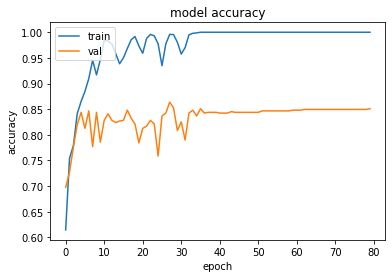

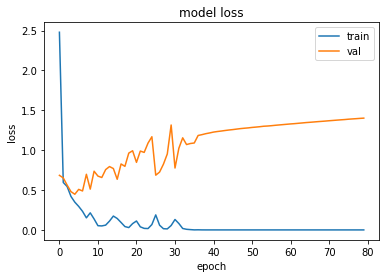

In [10]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### Confusion Matrix

In [11]:
#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, steps=np.math.ceil(validation_generator.samples/validation_generator.batch_size), verbose=1, workers=0)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

23/23 [==============================] - 1s 52ms/step
Confusion Matrix
[[266  15  16]
 [ 19 180  19]
 [ 23  15 171]]


## Classification Report

In [12]:
target_names = list(validation_generator.class_indices.keys())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

                 precision    recall  f1-score   support

    food_resize       0.86      0.90      0.88       297
landmark_resize       0.86      0.83      0.84       218
  people_resize       0.83      0.82      0.82       209

       accuracy                           0.85       724
      macro avg       0.85      0.85      0.85       724
   weighted avg       0.85      0.85      0.85       724



# Plot Model

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, 
           to_file=os.path.join(PROJECT_DIR, modelname+'_model.png'), 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')